In [7]:
import cv2
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm


In [2]:
count_cells = []
for json_file in os.listdir('data/generated'):
    if json_file.endswith('.json'):
        file = json.load(open('data/generated/' + json_file))
        for cell in file['cell']:
            if len(cell) > 0 and len(cell) < 200:
                count_cells.append(len(cell))

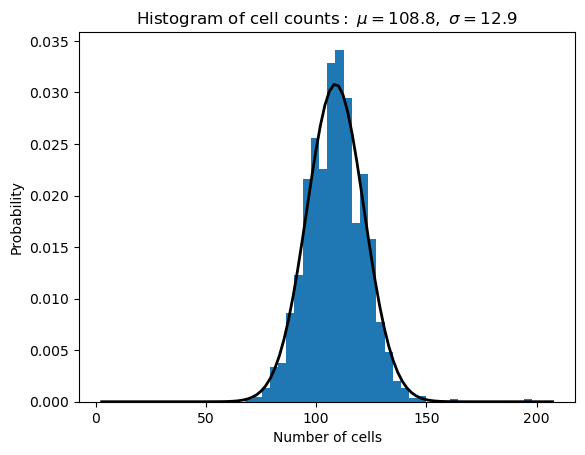

In [3]:
count_cells = np.array(count_cells)
plt.hist(count_cells, bins=50, density=True)
mu, std = norm.fit(count_cells)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Number of cells')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ cell\ counts:}\ \mu=%.1f,\ \sigma=%.1f$' % (mu, std))
plt.show()

In [4]:
images = []

for tif_file in os.listdir('data/droplets'):
    if tif_file.endswith('.tif'):
        img = cv2.imreadmulti('data/droplets/' + tif_file)[1]
        for im in img:
            images.append(im)

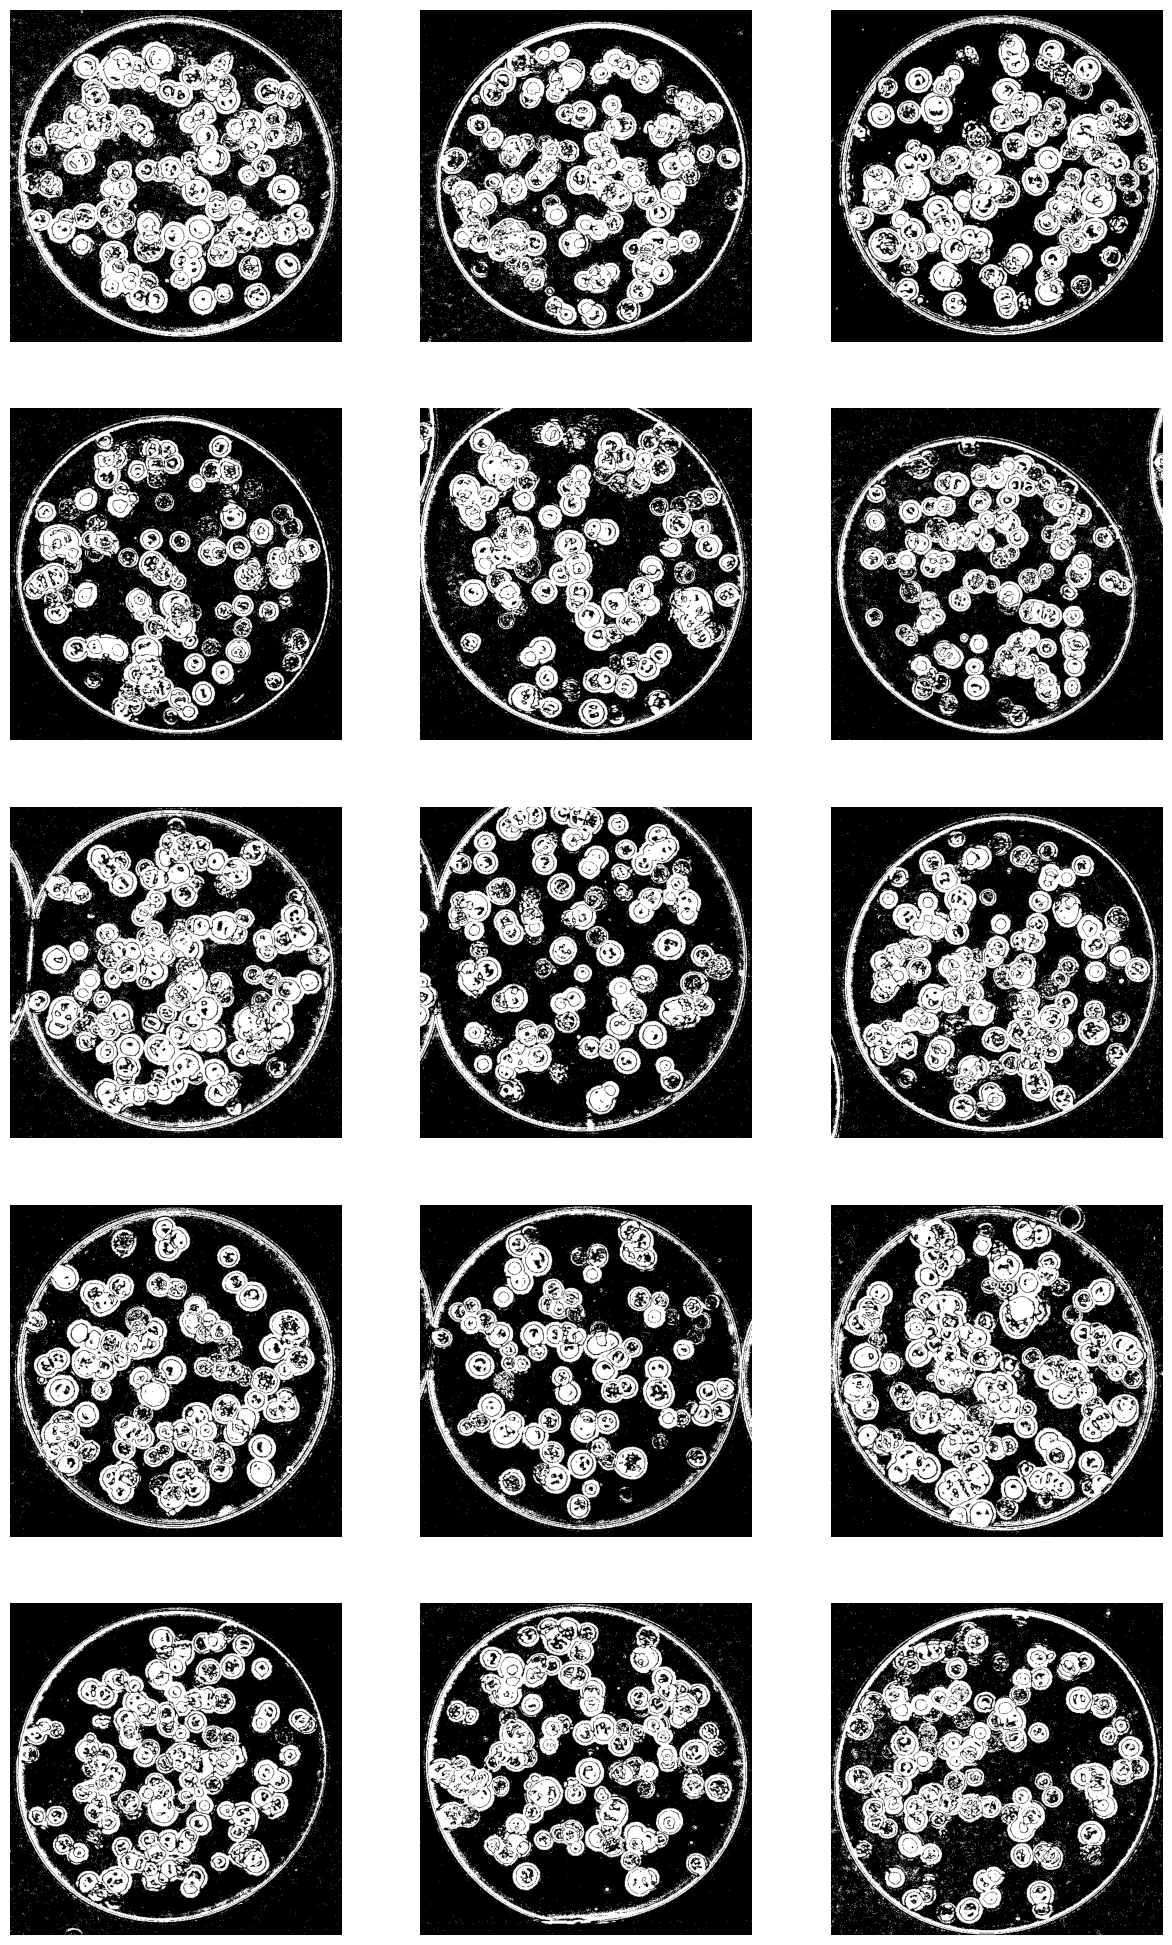

In [5]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
for ax in axs.flatten():
    ax.imshow(images[np.random.randint(len(images))], cmap='gray')
    ax.axis('off')  
plt.show()

### remove outside droplet

In [8]:
images_circle = []
for im in tqdm(images):
    circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=250, maxRadius=350)
    mask = np.zeros_like(im)
    if circles is not None:
        circle = np.array(circles[0][0], dtype=int)
        mask = cv2.circle(mask, (circle[0],circle[1]), circle[2], (255, 255, 255), -1)
        images_circle.append(cv2.bitwise_and(im, mask))
    else:
        images_circle.append(im)


  0%|          | 0/2358 [00:00<?, ?it/s]

 28%|██▊       | 672/2358 [02:54<07:18,  3.84it/s]


KeyboardInterrupt: 

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# axs[0, 0].imshow(images[0], cmap='gray')
# axs[0, 0].set_title('Original')
# axs[0, 0].axis('off')
# axs[0, 1].imshow(images_circle[0], cmap='gray')
# axs[0, 1].set_title('Cropped')
# axs[0, 1].axis('off')
# axs[1, 0].imshow(images[1], cmap='gray')
# axs[1, 0].set_title('Original')
# axs[1, 0].axis('off')
# axs[1, 1].imshow(images_circle[1], cmap='gray')
# axs[1, 1].set_title('Cropped')
# axs[1, 1].axis('off')
# plt.show()


In [ ]:
# fig, axs = plt.subplots(5, 3, figsize=(15, 25))
# for ax in axs.flatten():
#     ax.imshow(images_circle[np.random.randint(len(images_circle))], cmap='gray')
#     ax.axis('off')

### Find cells location

In [ ]:
cells_preds = []
for im in images_circle:
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1, 12, param1=50, param2=15, minRadius=14, maxRadius=30)[0]
    cells_preds.append(np.array(circles)[:,0:2])


In [ ]:
len(cells_preds)

## Summary

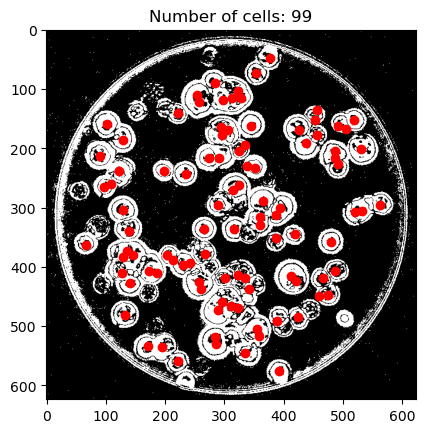

100


In [35]:
def get_cells_list(droplet):
    # Remove outside droplet
    circles = cv2.HoughCircles(droplet, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=250, maxRadius=350)
    mask = np.zeros_like(droplet)
    if circles is not None:
        circle = np.array(circles[0][0], dtype=int)
        mask = cv2.circle(mask, (circle[0],circle[1]), circle[2], (255, 255, 255), -1)
        droplet = cv2.bitwise_and(droplet, mask)
    # opening to remove noise
    droplet = cv2.morphologyEx(droplet, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    # find cells with hough circles
    circles = cv2.HoughCircles(droplet, cv2.HOUGH_GRADIENT, 1, 12, param1=50, param2=15, minRadius=14, maxRadius=30)[0]
    return np.array(circles)[:,0:2]

def plot_preds(droplet):
    preds = get_cells_list(droplet)
    plt.imshow(droplet, cmap='gray')
    plt.scatter(preds[:,0], preds[:,1], c='r')
    plt.title('Number of cells: {}'.format(len(preds)))
    plt.show()

idx = np.random.randint(len(images))
plot_preds(images[idx])
print(count_cells[idx])